### Import Efficient 3DCNN MobileNetV2

In [1]:
import sys
sys.path.append('../Face Liveness/Models/Efficient-3DCNNs-master/models')

In [2]:
from mobilenetv2 import MobileNetV2, get_model, get_fine_tuning_parameters
from copy import deepcopy

In [3]:
# Create an instance of the MobileNetV2 model
base_model = MobileNetV2(num_classes=27, sample_size=112, width_mult=1.0)

In [4]:
base_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(16, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2

### Load the pre-train / checkpoint

In [5]:
import torch

checkpoint_path = './jester_mobilenetv2_1.0x_RGB_16_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

C:\Users\andre\AppData\Local\Temp\ipykernel_2412\2468774626.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [6]:
# Remove the 'module.' prefix from the state_dict keys
new_state_dict = {}
for k, v in checkpoint['state_dict'].items():
    new_key = k.replace('module.', '')  # Remove 'module.' from key names
    new_state_dict[new_key] = v

# Load the new state_dict into your model
base_model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [7]:
# Print the original classifier structure
print("Original classifier:", base_model.classifier)

Original classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=27, bias=True)
)


In [8]:
# Access the last layer in the classifier to get in_features
if isinstance(base_model.classifier, torch.nn.Sequential):
    # Assuming the last layer is a Linear layer
    last_layer = base_model.classifier[-1]  # Access the last layer in the Sequential
    in_features = last_layer.in_features  # Get the number of input features
else:
    in_features = base_model.classifier.in_features  # If it's a Linear layer directly

print("Input features for the classifier:", in_features)

Input features for the classifier: 1280


### Folders

In [9]:
train_folder = '../../Dataset/CASIA-FASD/train_release'
test_folder = '../../Dataset/CASIA-FASD/test_release'

new_train_folder = '../../Dataset/CASIA-FASD/train'
validation_folder = '../../Dataset/CASIA-FASD/validation'

In [10]:
import os
import shutil
import random
from video_dataset import VideoDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

In [12]:
identities = os.listdir(train_folder)

# split original train data --> train(80%)/validation(20%), original train data identities=20
num_val_identities = 4 #original train data * 0.2 = 4
val_identities = random.sample(identities, num_val_identities)

In [13]:
# Copy to new folders
def make_new_folder():
    for identity in identities:
        identity_path = os.path.join(train_folder, identity)

        if identity in val_identities:
            dest_folder = os.path.join(validation_folder, identity)
        else:
            dest_folder = os.path.join(new_train_folder, identity)

        os.makedirs(dest_folder, exist_ok=True)

        for video_file in os.listdir(identity_path):
            src_file = os.path.join(identity_path, video_file)
            shutil.copy(src_file, dest_folder)

In [14]:
# make_new_folder()

In [15]:
base_train_dataset = VideoDataset(train_folder)
base_train_loader = DataLoader(base_train_dataset)

In [16]:
# train_dataset = VideoDataset(new_train_folder)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [17]:
# validation_dataset = VideoDataset(validation_folder)
# validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

In [18]:
test_dataset = VideoDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

##### Show sample of the first video

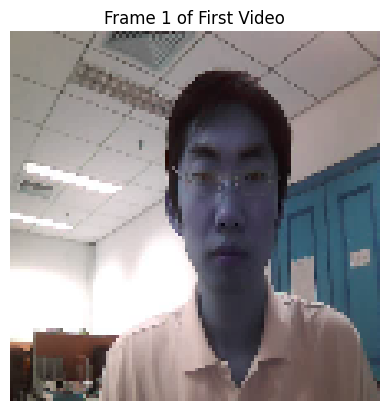

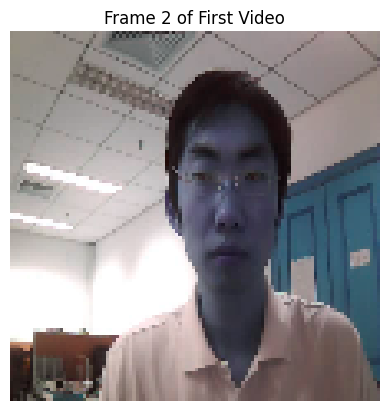

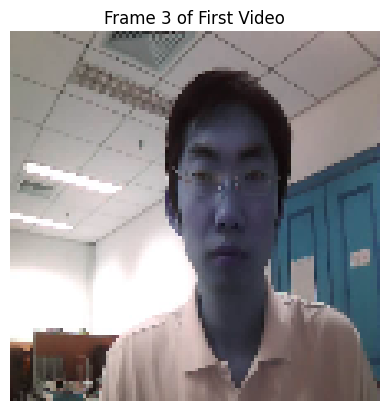

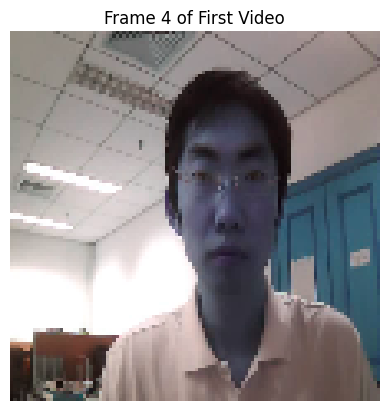

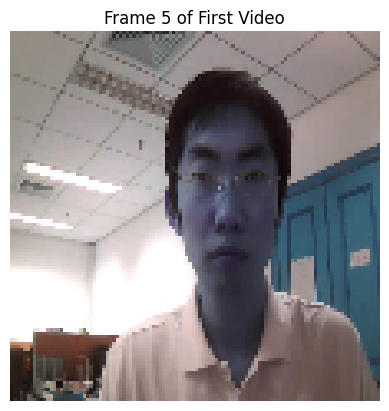

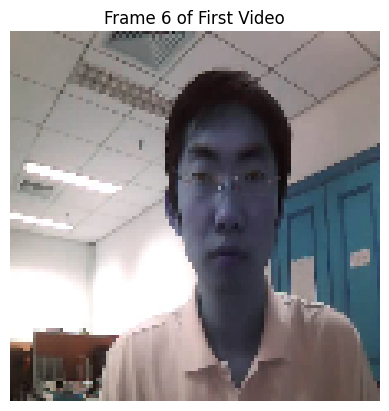

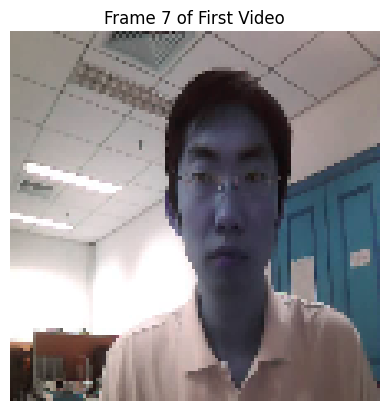

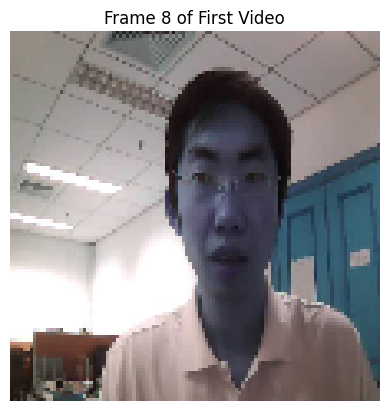

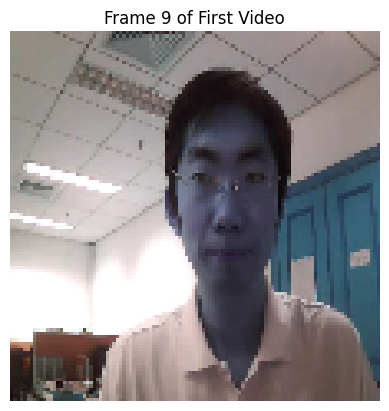

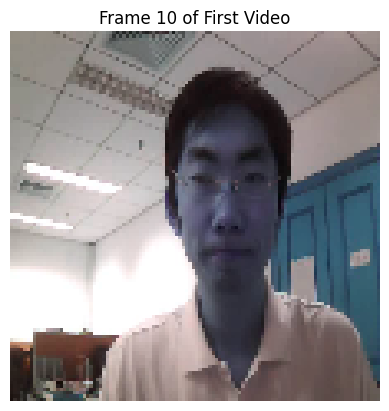

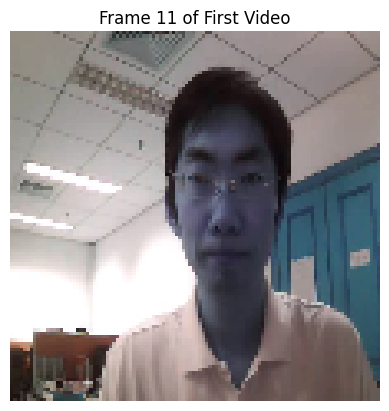

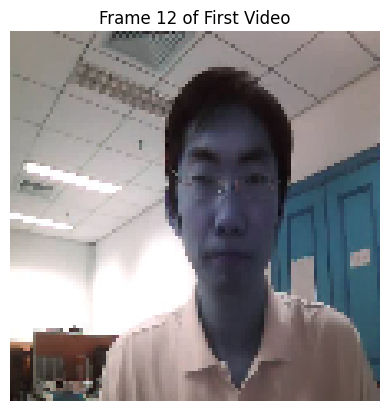

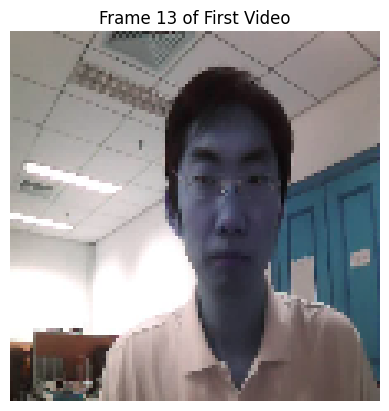

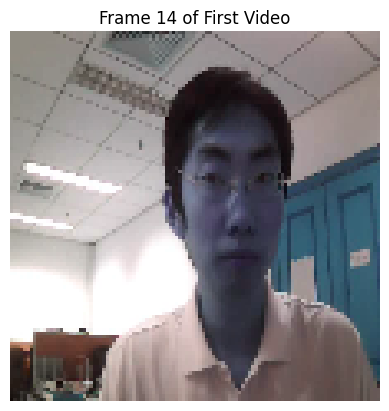

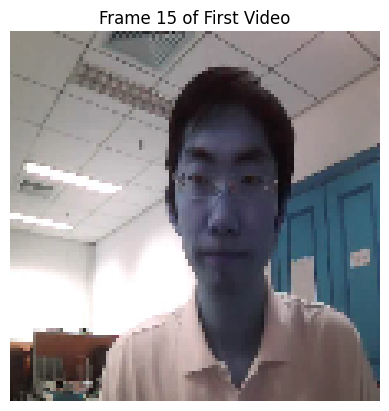

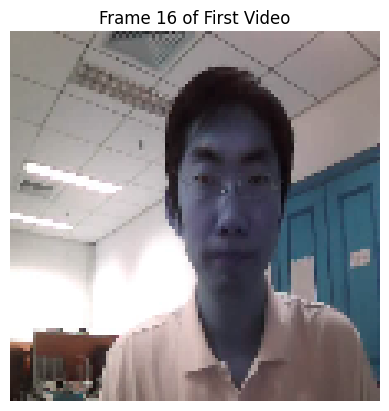

In [19]:
for frames, labels in base_train_loader:  # Unpack frames and labels
    for i in range(frames.size(1)):  # frames.size(1) gives the number of frames in the first video
        plt.imshow(frames[0][i].permute(1, 2, 0).numpy())  # Show the i-th frame of the first video
        plt.axis('off')  # Hide axis
        plt.title(f'Frame {i + 1} of First Video')
        plt.show()
    
    break  # Exit after the first batch

#### Check data shape

In [20]:
# Check the length of the train dataset
print("Number of videos in train dataset:", len(base_train_dataset))
print("Number of videos in test dataset:", len(test_dataset))

# Check the return value of the first item in the dataset
sample_frames, sample_label = base_train_dataset[0]  # Get the first video
print("Return value for the first video (frames, label):", (sample_frames, sample_label))

# Check the shape of the frames
if isinstance(sample_frames, torch.Tensor):
    print("Shape of frames for the first video:", sample_frames.shape)
else:
    print("The first video frames are not a tensor, inspect further.")


Number of videos in train dataset: 240
Number of videos in test dataset: 360
Return value for the first video (frames, label): (tensor([[[[145, 147, 147,  ..., 160, 160, 158],
          [145, 147, 147,  ..., 157, 157, 154],
          [147, 147, 147,  ..., 157, 157, 155],
          ...,
          [ 34,  37,  39,  ..., 102, 100,  94],
          [ 31,  34,  30,  ...,  92,  95, 104],
          [ 29,  52,  28,  ..., 102, 101, 101]],

         [[140, 142, 142,  ..., 145, 147, 141],
          [140, 142, 142,  ..., 142, 144, 137],
          [142, 142, 142,  ..., 142, 144, 138],
          ...,
          [ 20,  28,  35,  ...,  89,  91,  87],
          [ 17,  25,  26,  ...,  89,  90,  93],
          [ 15,  43,  24,  ...,  87,  89,  89]],

         [[125, 127, 127,  ..., 141, 138, 142],
          [125, 127, 127,  ..., 138, 135, 138],
          [127, 127, 127,  ..., 137, 135, 139],
          ...,
          [ 18,  25,  31,  ...,  85,  83,  85],
          [ 14,  22,  22,  ...,  84,  82,  90],
       

### Insert Data to Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
print(device)

cuda


In [23]:
import torch.nn as nn
import torch.optim as optim

In [24]:
num_classes = 2
base_model.classifier[1] = nn.Linear(base_model.last_channel, num_classes)

In [25]:
base_model = base_model.to(device)

In [26]:
base_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv3d(16, 96, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.0001)

In [28]:
num_epochs = 10
patience = 3
train_losses = []

In [29]:
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()  # Set model to training mode
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Ensure model is in training mode

        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)

            # Convert inputs to float if they are not already
            if inputs.dtype != torch.float32:
                inputs = inputs.float()  # Convert to FloatTensor

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    print("Base training complete.")

    return model, train_losses

In [30]:
model, train_losses = train(base_model, base_train_loader, criterion, optimizer, num_epochs, device)

Epoch 1/10, Train Loss: 0.6041
Epoch 2/10, Train Loss: 0.3996
Epoch 3/10, Train Loss: 0.2914
Epoch 4/10, Train Loss: 0.1980
Epoch 5/10, Train Loss: 0.1379
Epoch 6/10, Train Loss: 0.0934
Epoch 7/10, Train Loss: 0.0632
Epoch 8/10, Train Loss: 0.0462
Epoch 9/10, Train Loss: 0.0359
Epoch 10/10, Train Loss: 0.0280
Base training complete.


In [31]:
print(train_losses)

[0.6041156746447086, 0.399633612173299, 0.2913823123710851, 0.19798488253727556, 0.13792001303906243, 0.09343021603611608, 0.06320637409420063, 0.04622342103781799, 0.0358594066890267, 0.028001236876783273]


In [32]:
def plot_losses(name, losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label=f'{name} losses', color='blue', marker='o')
    plt.title(f'{name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(len(losses)))  # Set x-ticks to be the epoch numbers
    plt.grid(True)
    plt.legend()
    plt.show()

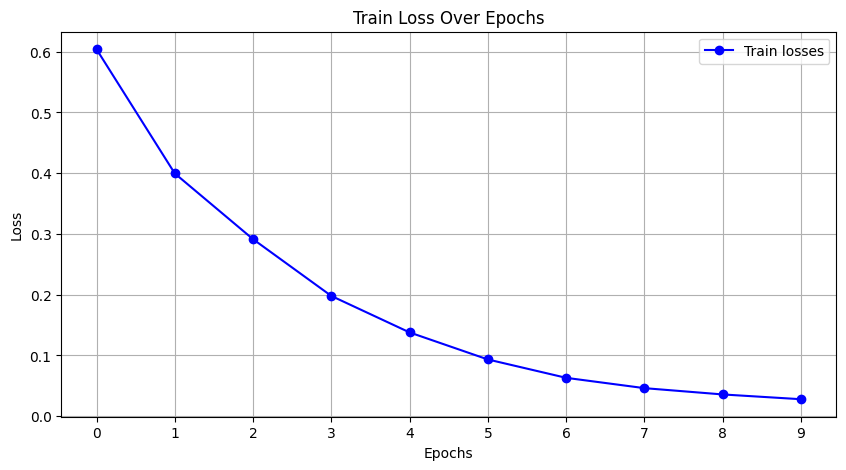

In [33]:
plot_losses('Train', train_losses)

In [34]:
from sklearn.metrics import classification_report

In [35]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation is needed during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjust input dimensions if necessary

            if inputs.dtype != torch.float32:
                inputs = inputs.float()  # Convert to FloatTensor

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            test_losses.append(loss.item())  # Store the loss for later

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses) if test_losses else 0

    print(classification_report(all_labels, all_predictions, target_names=['Genuine', 'Spoof']))
    return avg_test_loss

In [36]:
test_loss = test(model, test_loader, criterion, device)

              precision    recall  f1-score   support

     Genuine       1.00      0.03      0.05       240
       Spoof       0.34      1.00      0.51       120

    accuracy                           0.35       360
   macro avg       0.67      0.51      0.28       360
weighted avg       0.78      0.35      0.20       360

